In [1]:
import bn
import ocr_data
import numpy as np
from IPython.display import clear_output
from importlib import reload
reload(bn)

<module 'bn' from '/home/benland100/Desktop/bn/bn.py'>

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3

In [3]:
input_shape = ocr_data.in_2d_shape
conv_kernels = [(3,3)]
conv_outs = [(3,)]
conv_layers = len(conv_kernels)
hidden_shapes = [(5,10)]
hidden_layers = len(hidden_shapes)
output_shape = ocr_data.out_shape
print(input_shape,output_shape)

(8, 8) (25,)


In [4]:
layers = []
layers.append(bn.Input(input_shape))
for kernel_shape,out_shape in zip(conv_kernels,conv_outs):
    layers.append(bn.Conv(kernel_shape,out_shape=out_shape))
for hidden_shape in hidden_shapes:
    layers.append(bn.Dense(hidden_shape))
layers.append(bn.Output(output_shape))

s = bn.System()
insts = []
inputs = None
for layer in layers:
    insts.append(layer.construct(s,inputs))
    inputs = insts[-1].outputs
    print(layer, inputs.shape)
s.finalize()

<bn.Input object at 0x7fad34725910> (8, 8)
<bn.Conv object at 0x7fad34725a00> (6, 6, 3)
<bn.Dense object at 0x7fad34725b20> (5, 10)
<bn.Output object at 0x7fad34725970> (25,)


In [5]:
print('IN: %s OUT: %s TOTAL: %i WEIGHTS: %i'%(input_shape,output_shape,len(s.neurons),np.sum([len(n.weights) for n in s.neurons])))

IN: (8, 8) OUT: (25,) TOTAL: 247 WEIGHTS: 7622


In [6]:
def batch(length=10):
    cases = []
    successes = []
    for true_out,input in ocr_data.tagged_data(length):
        guess_out,state = s.guess(input,return_state=True)
        if np.any(guess_out != true_out):
            successes.append(False)
            s.learn(state,true_out,scale=1.0,noise=None)
        else:
            successes.append(True)
    return cases,successes

In [21]:
try:
    while True:
        batch_size = 10000
        cases,successes = batch(batch_size)
        correct = np.count_nonzero(successes)
        print('batch accuracy',correct,'/',len(successes))
        if correct/len(successes) > 0.99:
            break
except KeyboardInterrupt:
    print('Stopped by user')

batch accuracy 9577 / 10000
batch accuracy 9674 / 10000
batch accuracy 9572 / 10000
batch accuracy 9586 / 10000
batch accuracy 9611 / 10000
batch accuracy 9650 / 10000
batch accuracy 9503 / 10000
batch accuracy 9681 / 10000
batch accuracy 9703 / 10000
batch accuracy 9654 / 10000
Stopped by user


-3015112787.857099


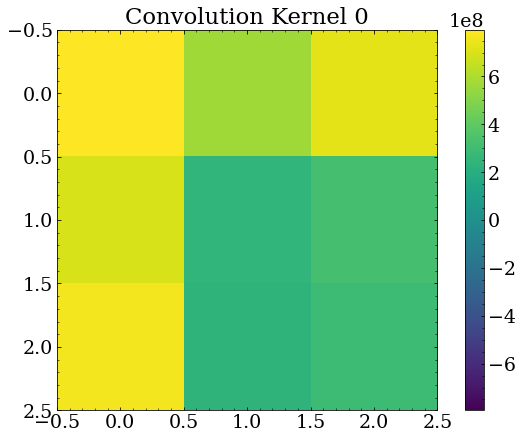

-752268948.2538085


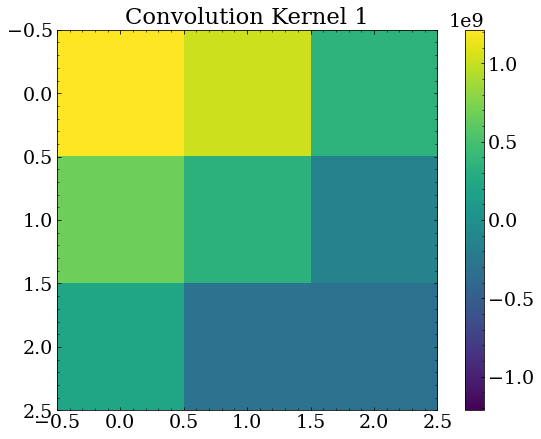

693003864.402031


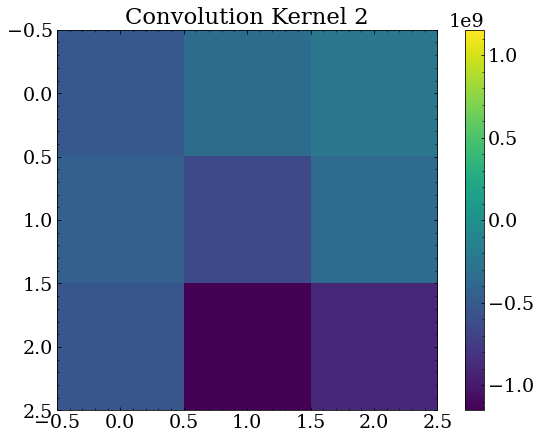

In [22]:
from matplotlib.colors import Normalize

for i,index in enumerate(np.ndindex(conv_outs[0])):
    img_conv = insts[1].neurons[i].weights.reshape(conv_kernels[0])
    print(insts[1].neurons[i].threshold)
    norm = np.max(np.abs(img_conv))
    norm = Normalize(-norm,norm)
    plt.figure()
    plt.title('Convolution Kernel %s'%index)
    plt.imshow(img_conv,norm=norm)
    plt.colorbar()
    plt.show()
    plt.close()

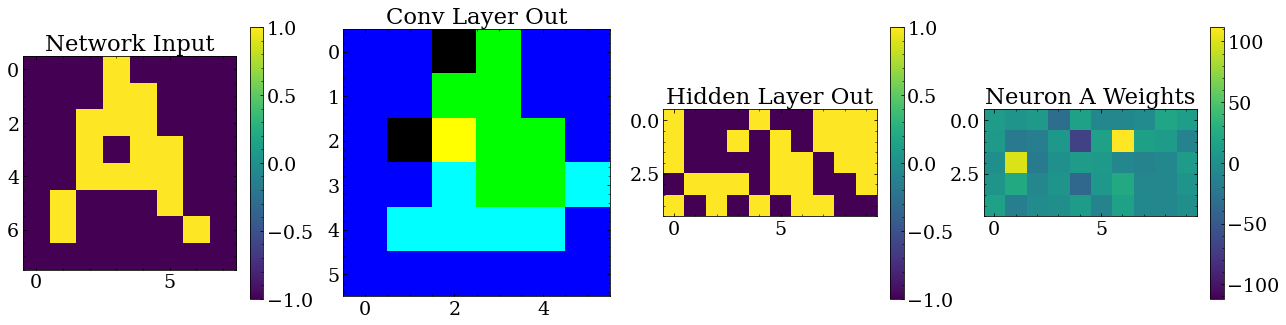

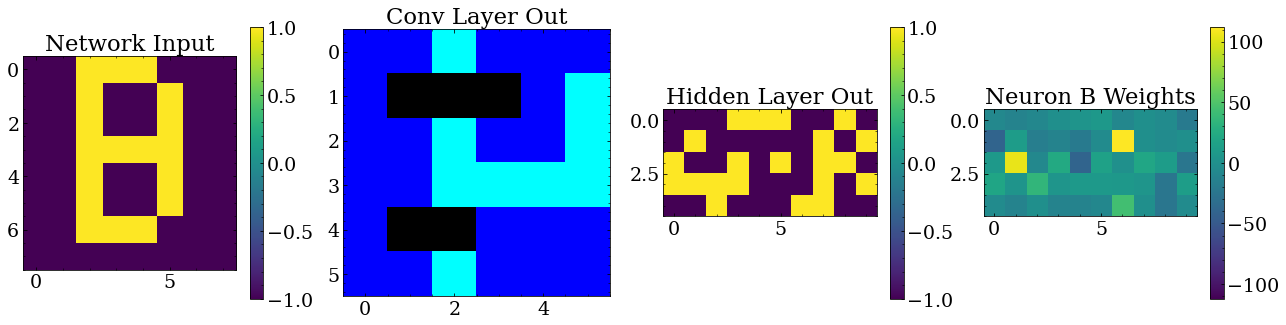

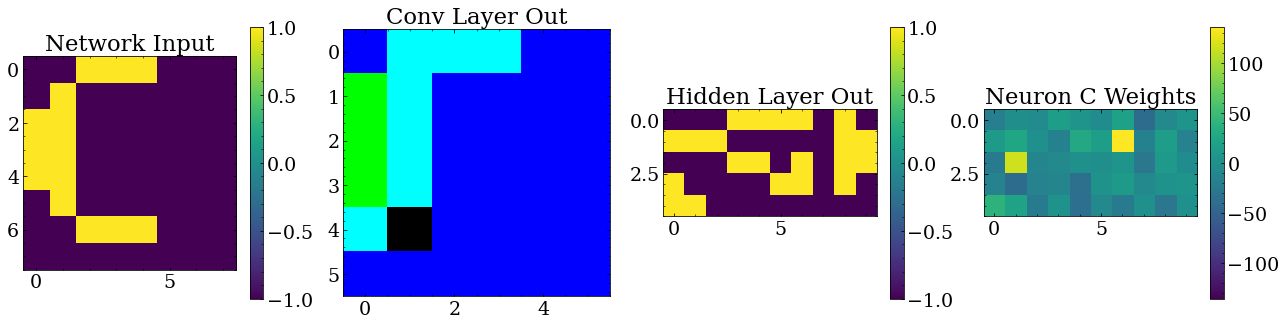

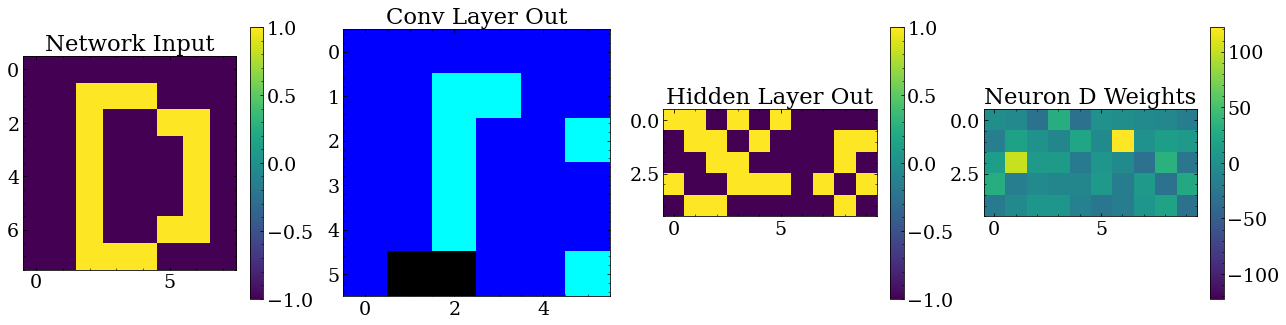

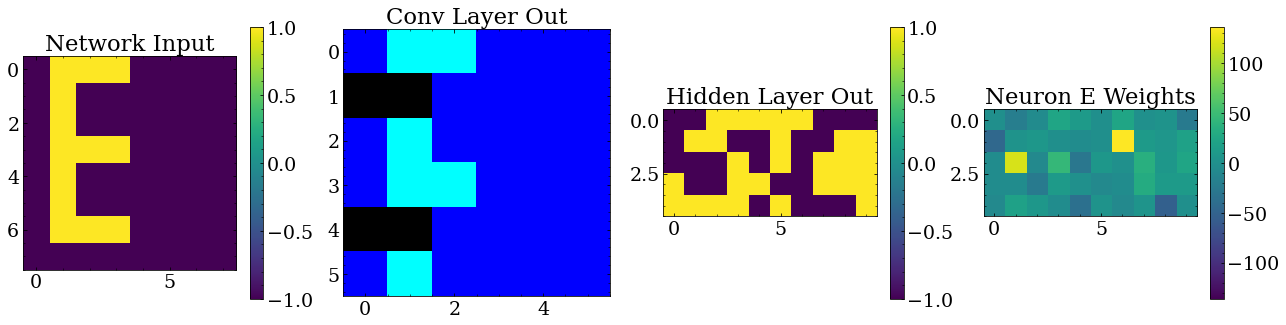

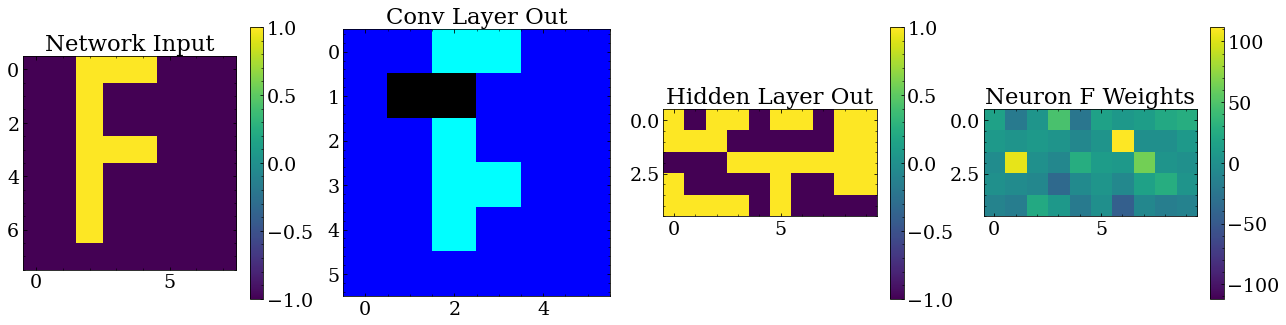

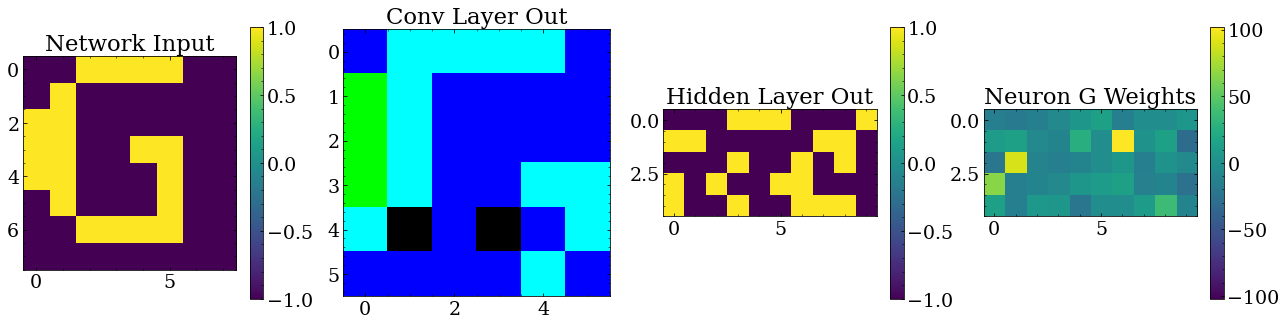

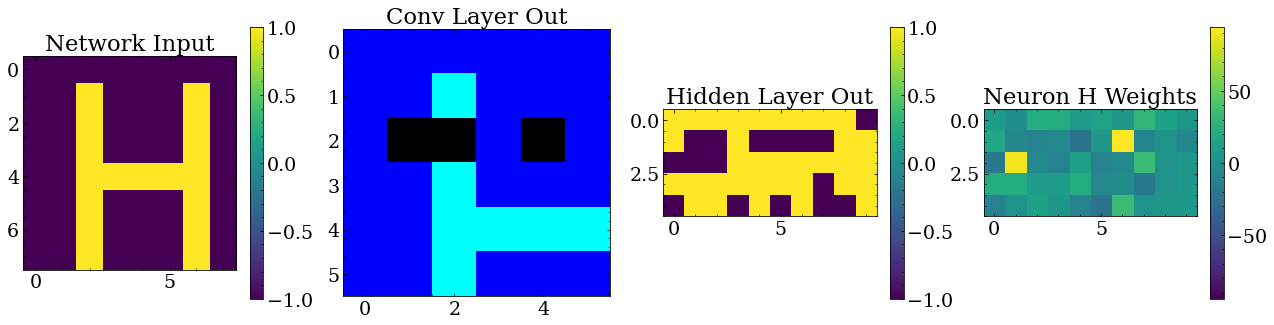

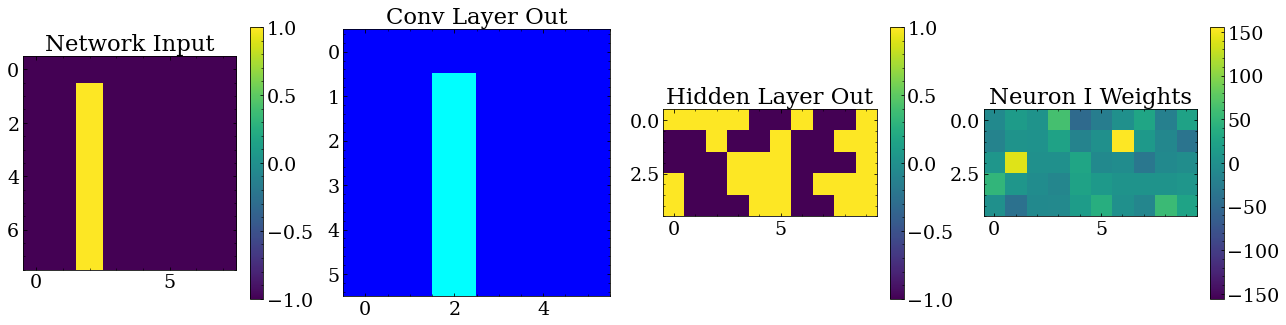

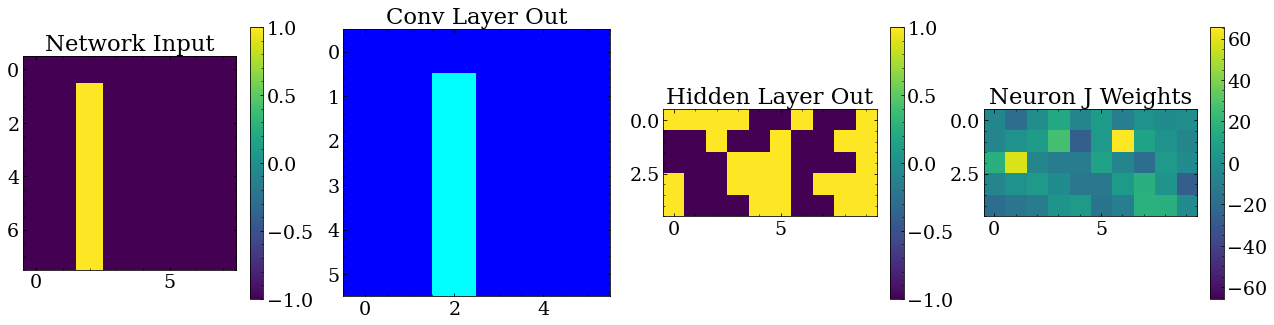

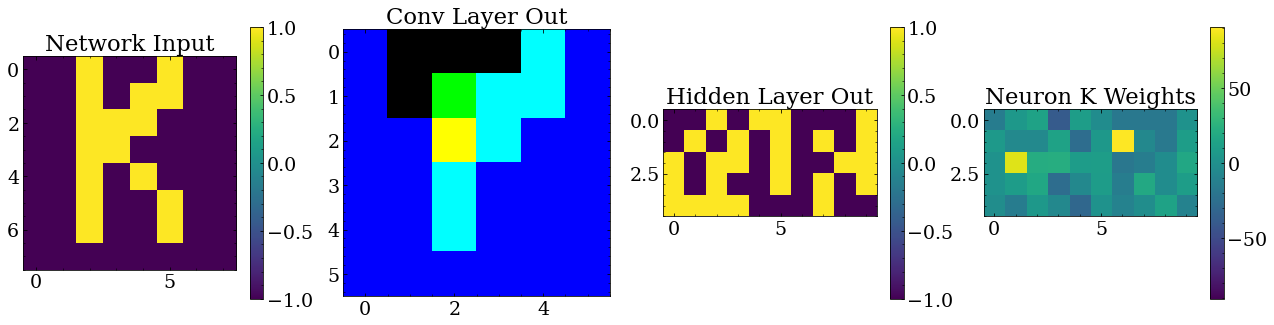

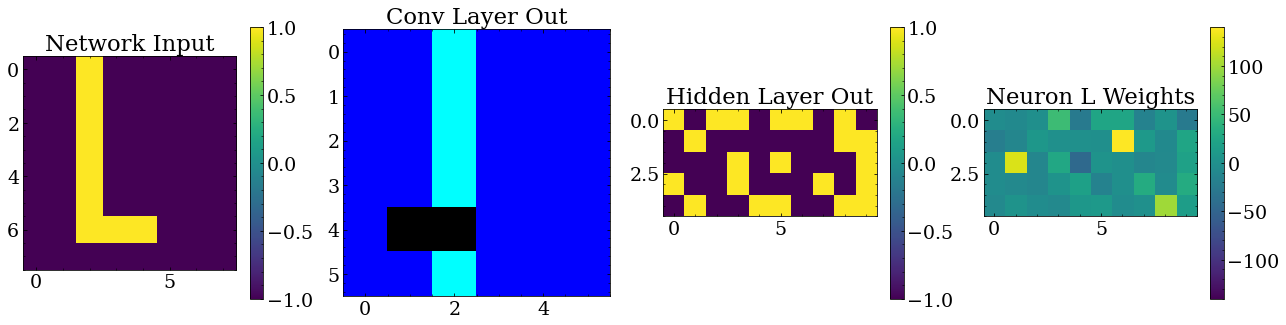

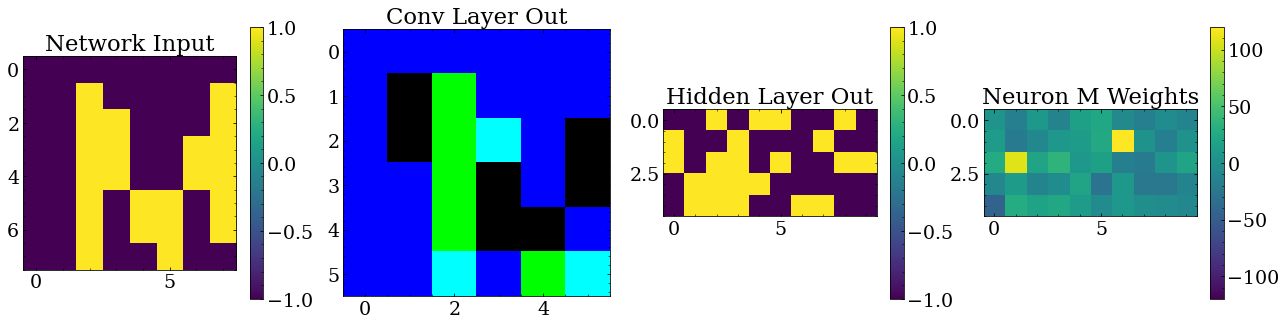

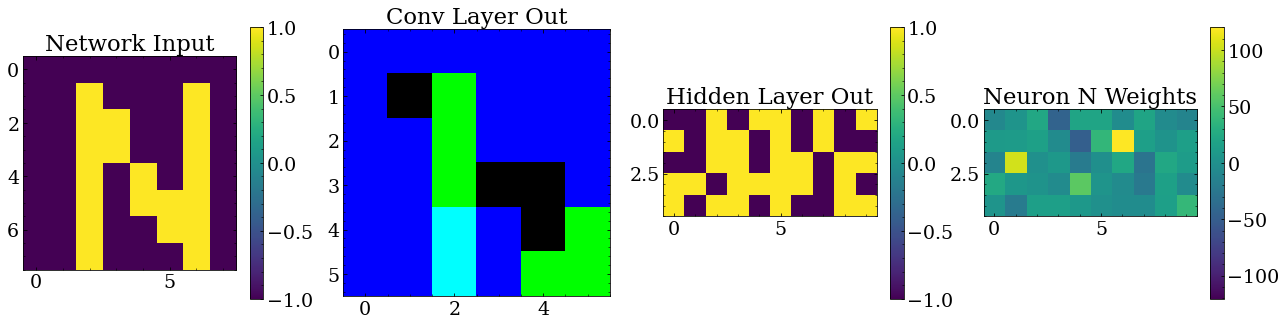

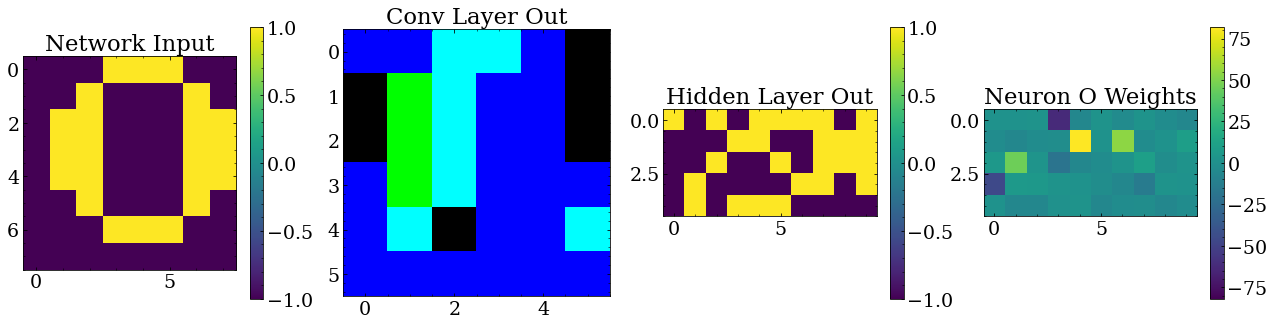

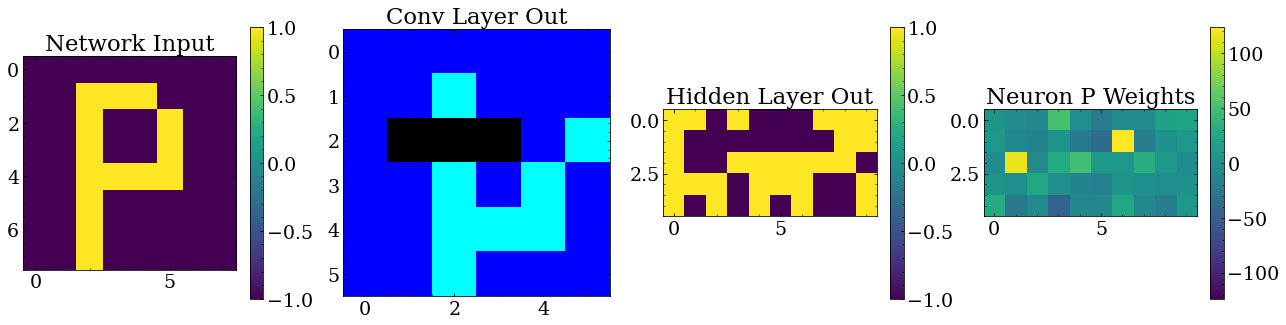

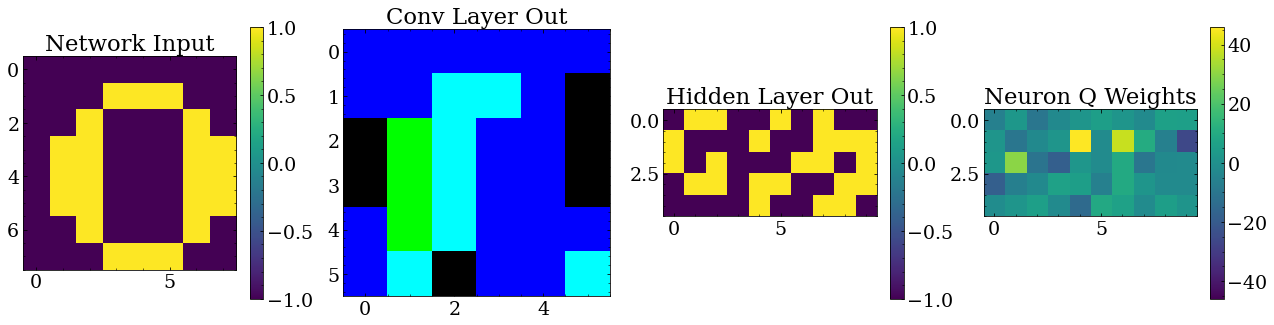

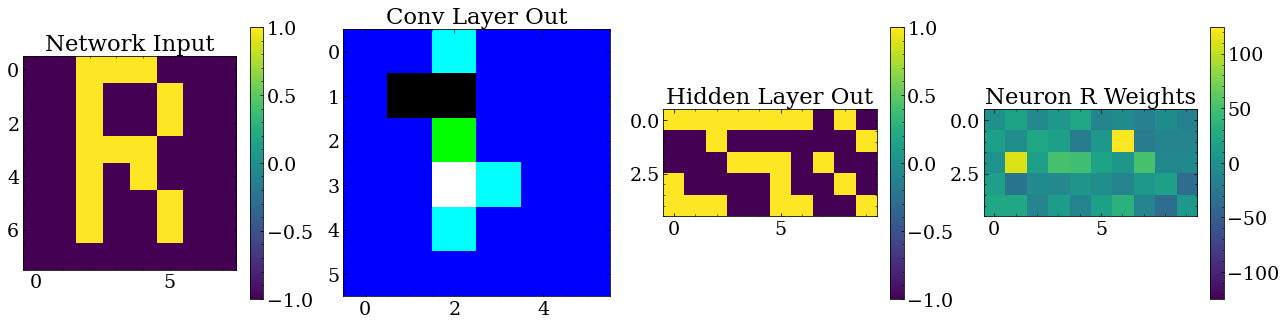

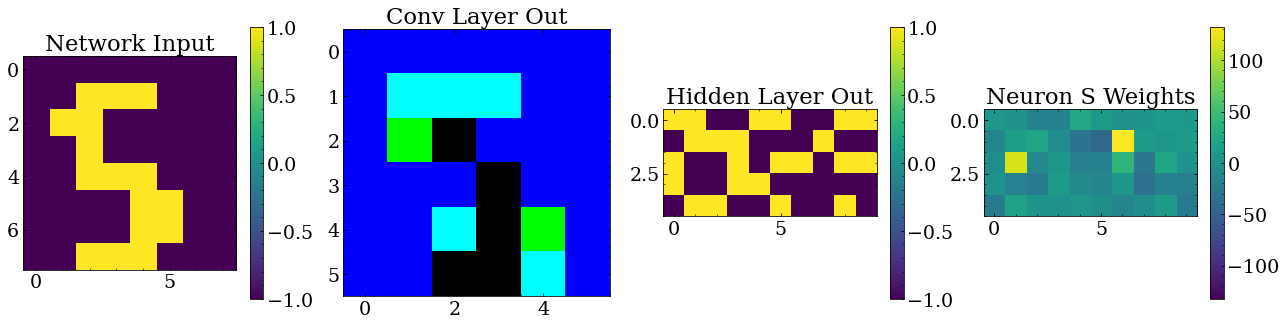

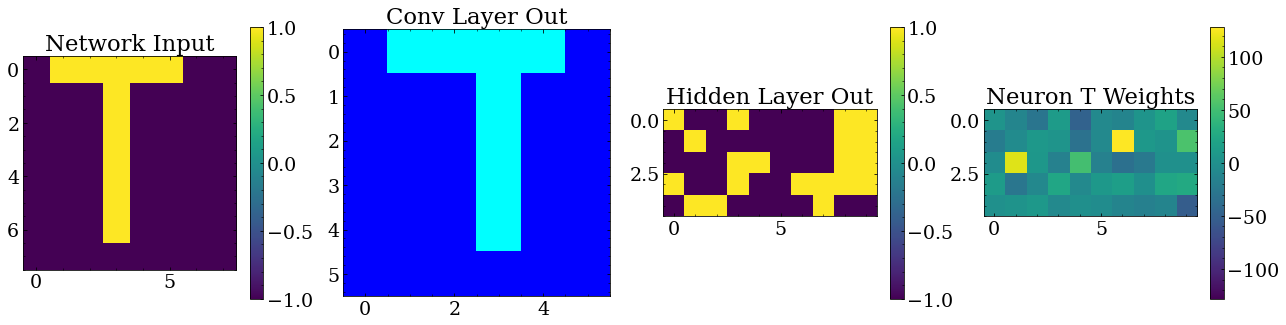

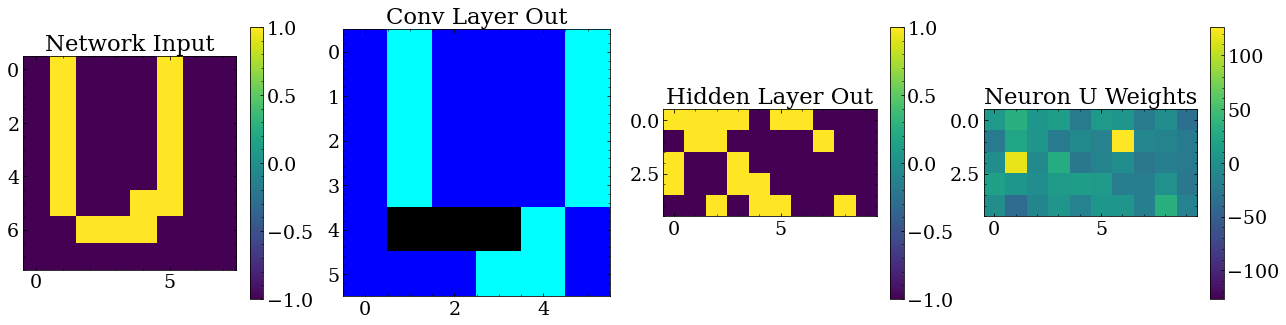

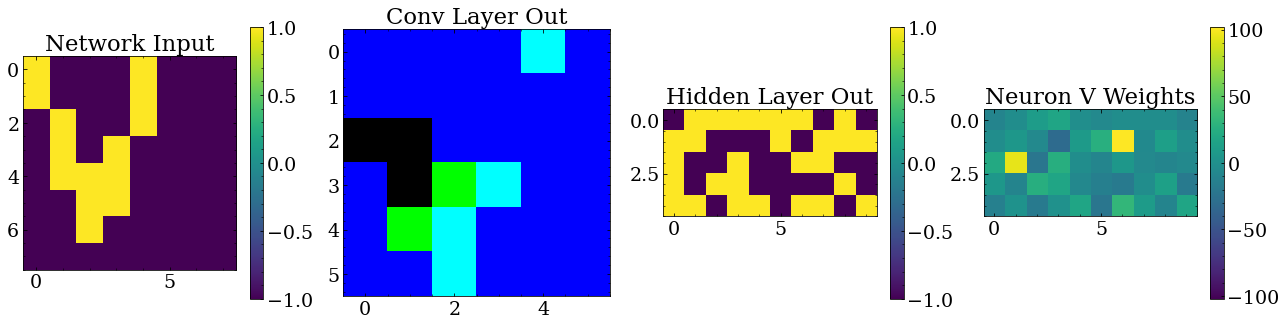

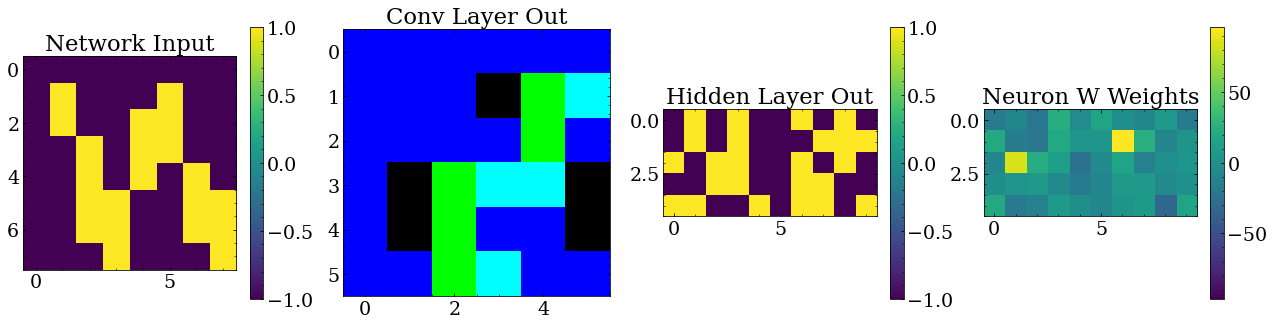

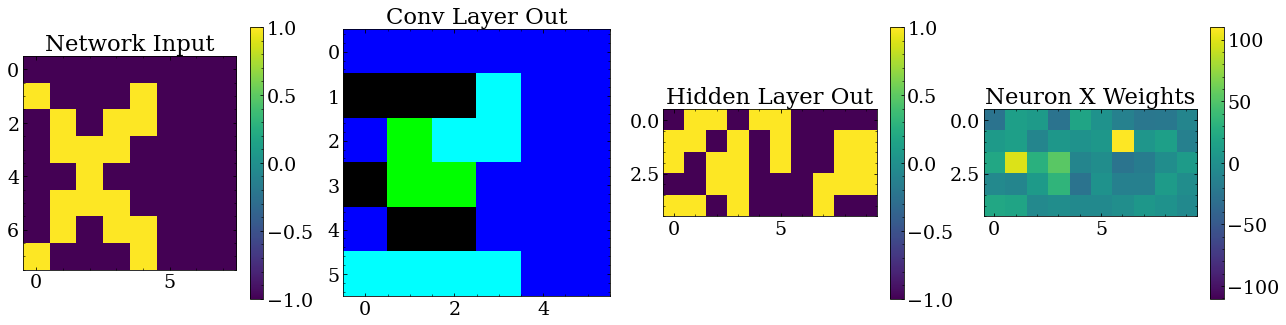

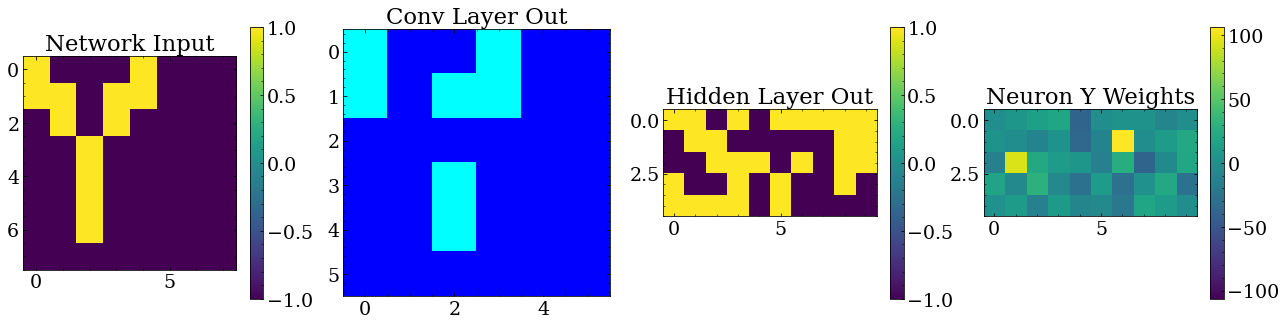

In [23]:
#to plot a simple one hidden layer network

from matplotlib.colors import Normalize

true_norm = Normalize(-1,1)
hidden_shapes = [(5,10)]

for i,iout in enumerate(s.outputs):
    letter = ocr_data.letters[i]
    test_in = ocr_data.gen_data(letter)[1]
    
    
    pltmagic = 100 + 20 + hidden_layers*10 + conv_layers*10
    plt.figure(figsize=[22,5])
    
    
    guess_out,state = s.guess(test_in.flatten(),return_state=True)
    inputs = insts[0].get_state(state)
    
    plt.subplot(pltmagic+1)
    plt.title('Network Input')
    plt.imshow(inputs,norm=true_norm)
    plt.colorbar()
    
    last_shape = test_in.shape
    for j in range(conv_layers):
        img_hidden = insts[1+j].get_state(state)
        
        plt.subplot(pltmagic+2+j)
        plt.title('Conv Layer Out')
        plt.imshow((img_hidden+1)/2)
        #plt.colorbar()
    
    
    for j in range(hidden_layers):
        img_hidden = insts[1+conv_layers+j].get_state(state)
    
        plt.subplot(pltmagic+2+conv_layers+j)
        plt.title('Hidden Layer Out')
        plt.imshow(img_hidden)
        plt.colorbar()

    plt.subplot(pltmagic+conv_layers+2+hidden_layers)
    plt.title('Neuron ''%s'' Weights'%letter)
    img_weights = insts[-1].neurons[i].weights.reshape(insts[-2].outputs.shape)
    norm = np.max(np.abs(img_weights))
    weight_norm = Normalize(-norm,norm)
    plt.imshow(img_weights,norm=weight_norm)
    plt.colorbar()
    plt.show()
    plt.close()